# Kaggle: [Cassava Leaf Disease Classification](https://www.kaggle.com/c/cassava-leaf-disease-classification)

This competition will challenge you to distinguish between several diseases that cause material harm to the food supply of many African countries. In some cases the main remedy is to burn the infected plants to prevent further spread, which can make a rapid automated turnaround quite useful to the farmers. 

This competition provides a farmer-crowdsourced dataset, labeled by experts at the National Crops Resources Research Institute (NaCRRI).

In [1]:
# system
import os
import json

# data
import numpy as np
import pandas as pd

# visuliazation
import seaborn as sn
import matplotlib.pyplot as plt

# computer vision
import cv2
import albumentations as A

# deep learning
from fastai.vision.all import *

# metrics
from sklearn import metrics as sk_metrics

In [2]:
BASE_DIR = "../../../../Datasets/cassava-leaf-disease-classification"

## Exploratory Data Analysis

In this competition we have 5 classes: 4 diseases and 1 healthy.

We can find the mapping between the class number and its name in the file `label_num_to_disease_map.json`

In [3]:
!tree $BASE_DIR -L 1

../../../../Datasets/cassava-leaf-disease-classification
├── label_num_to_disease_map.json
├── sample_submission.csv
├── test_images
├── test_tfrecords
├── train.csv
├── train_images
└── train_tfrecords

4 directories, 3 files


We can see that we have `train.csv` file with the train image names and labels, the `sample_submission.csv` with the test image names, and the `train` and `test` image folders. We also have the images in `tfrecords` format which is useful for quick loading of images, especially for TensorFlow and TPUs.

In [4]:
with open(os.path.join(BASE_DIR, "label_num_to_disease_map.json")) as file:
    map_classes = json.loads(file.read())
    
map_classes

{'0': 'Cassava Bacterial Blight (CBB)',
 '1': 'Cassava Brown Streak Disease (CBSD)',
 '2': 'Cassava Green Mottle (CGM)',
 '3': 'Cassava Mosaic Disease (CMD)',
 '4': 'Healthy'}

In [5]:
input_files = os.listdir(os.path.join(BASE_DIR, "train_images"))
print(f"Number of train images: {len(input_files)}")

Number of train images: 21397


We have > 20k images. Let's take a look at the dimensions of the first 300 images.

As you can see below, all images are the same size `(600, 800, 3)`.

In [6]:
img_shapes = {}
for image_name in os.listdir(os.path.join(BASE_DIR, "train_images"))[:300]:
    image = cv2.imread(os.path.join(BASE_DIR, "train_images", image_name))
    img_shapes[image.shape] = img_shapes.get(image.shape, 0) + 1

print(img_shapes)

{(600, 800, 3): 300}


Let's load the training dataframe and add a column with the real class name to it.

In [7]:
df_train = pd.read_csv(os.path.join(BASE_DIR, "train.csv"))
df_train["class_name"] = df_train["label"].astype(str).map(map_classes)

df_train

image_id  label                           class_name
0      1000015157.jpg      0       Cassava Bacterial Blight (CBB)
1      1000201771.jpg      3         Cassava Mosaic Disease (CMD)
2       100042118.jpg      1  Cassava Brown Streak Disease (CBSD)
3      1000723321.jpg      1  Cassava Brown Streak Disease (CBSD)
4      1000812911.jpg      3         Cassava Mosaic Disease (CMD)
...               ...    ...                                  ...
21392   999068805.jpg      3         Cassava Mosaic Disease (CMD)
21393   999329392.jpg      3         Cassava Mosaic Disease (CMD)
21394   999474432.jpg      1  Cassava Brown Streak Disease (CBSD)
21395   999616605.jpg      4                              Healthy
21396   999998473.jpg      4                              Healthy

[21397 rows x 3 columns]

In [8]:
df_train['path'] = df_train.image_id.apply(lambda x: f'{BASE_DIR}/train_images/{x}')

Let's look at the number of pictures in each class.

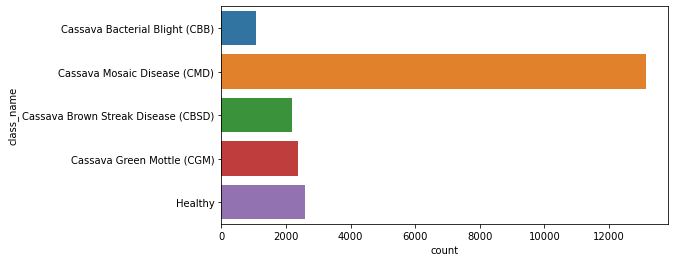

In [9]:
plt.figure(figsize=(8, 4))
sn.countplot(y="class_name", data=df_train);

As we can see, the dataset is imbalance.

# Visualization of train images

Let's see some sample images for various diseases.

In [10]:
def visualize_batch(image_ids, labels):
    """"""
    plt.figure(figsize=(16, 12))
    
    for ind, (image_id, label) in enumerate(zip(image_ids, labels)):
        plt.subplot(3, 3, ind + 1)
        image = cv2.imread(os.path.join(BASE_DIR, "train_images", image_id))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        plt.imshow(image)
        plt.title(f"Class: {label}", fontsize=14)
        plt.axis("off")
    
    plt.show()


def show_class_examples(disease_num = 4):
    """"""
    disease_name = map_classes[disease_num]
    tmp_df = df_train[df_train["label"] == int(disease_num)]
    print(f"Total train images for class {disease_num} ({disease_name}): {tmp_df.shape[0]}")

    tmp_df = tmp_df.sample(9)
    image_ids = tmp_df["image_id"].values
    labels = tmp_df["label"].values

    visualize_batch(image_ids, labels)

Total train images for class 0 (Cassava Bacterial Blight (CBB)): 1087


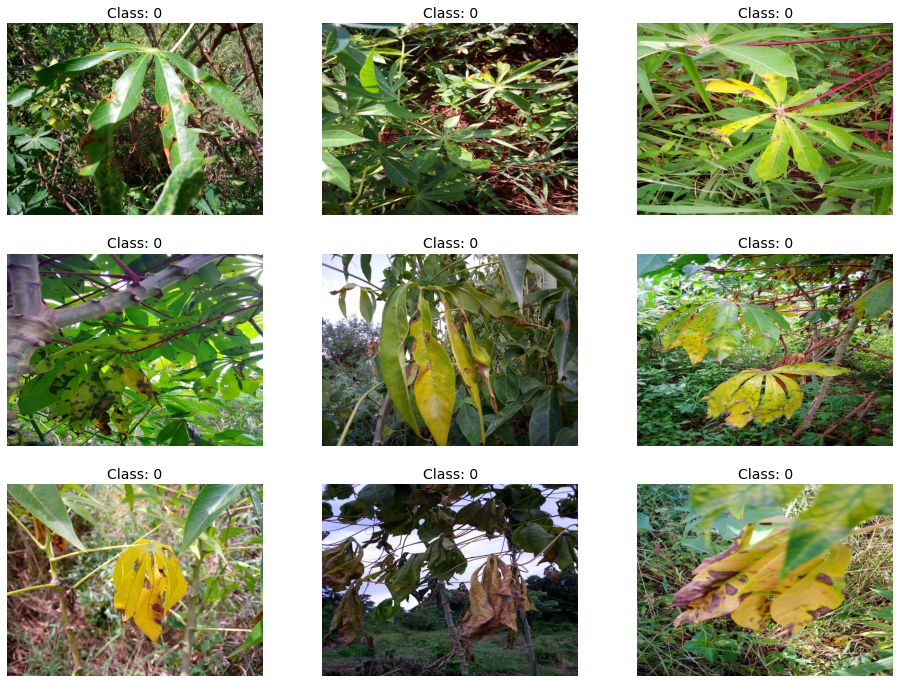

Total train images for class 1 (Cassava Brown Streak Disease (CBSD)): 2189


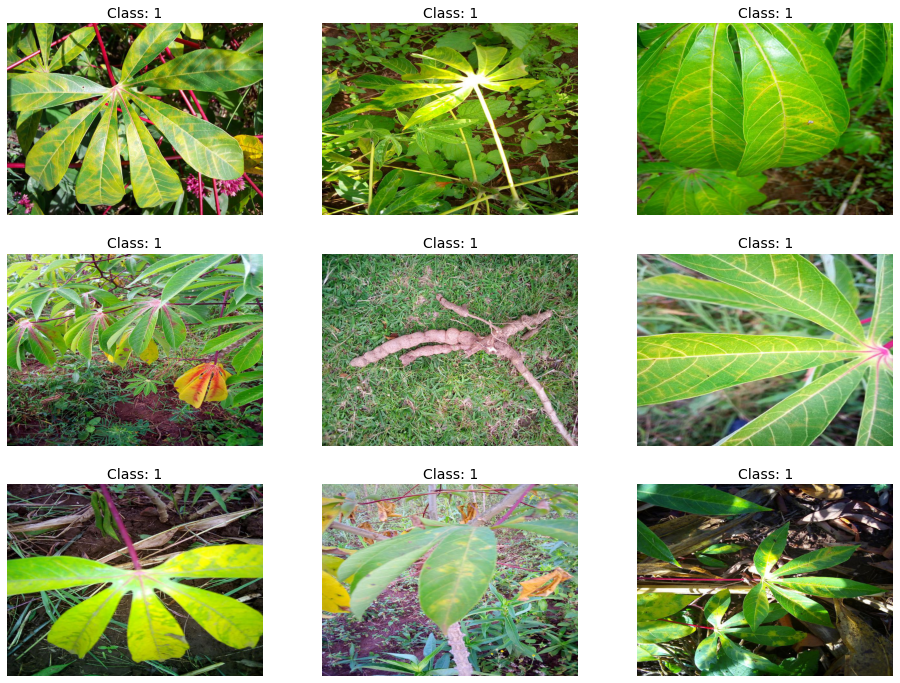

Total train images for class 2 (Cassava Green Mottle (CGM)): 2386


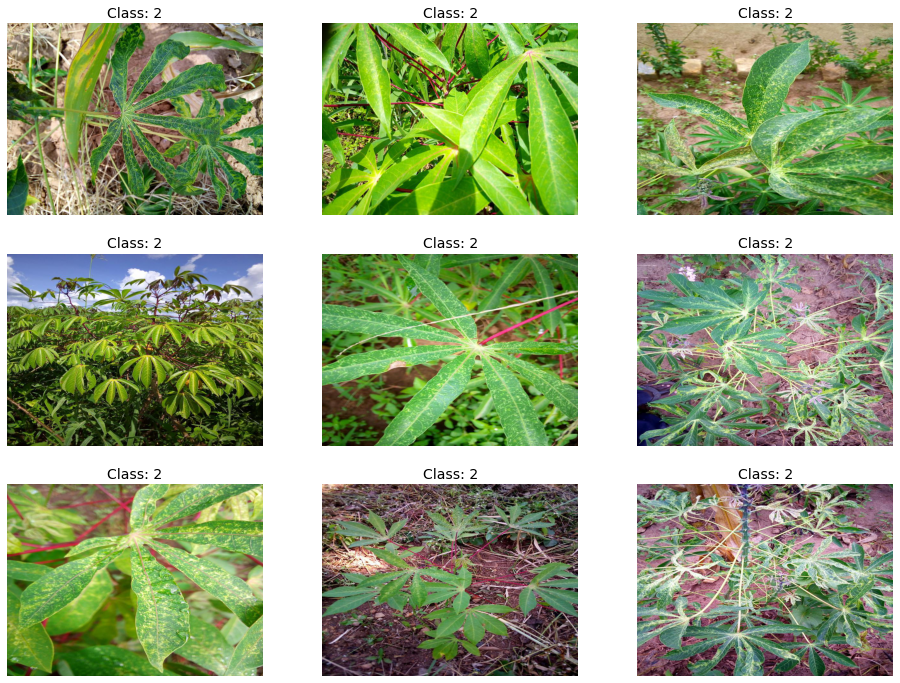

Total train images for class 3 (Cassava Mosaic Disease (CMD)): 13158


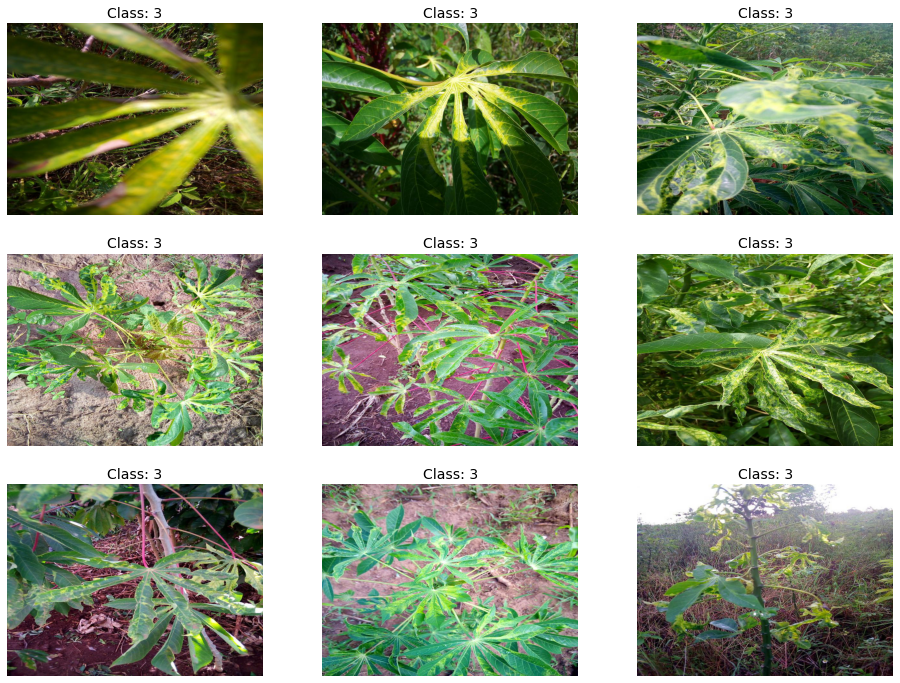

Total train images for class 4 (Healthy): 2577


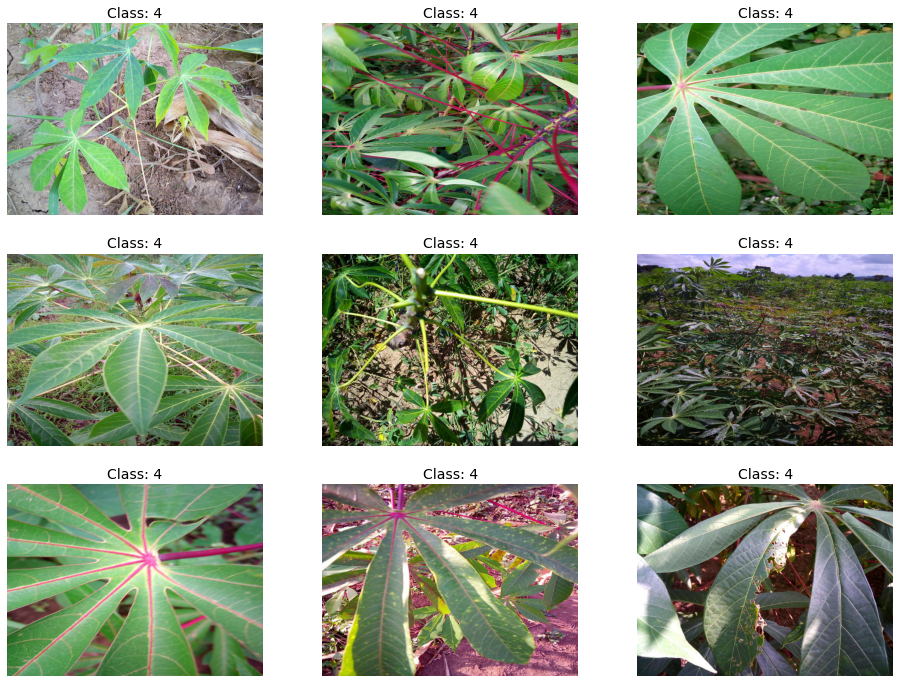

In [11]:
for disease_num in map_classes:
    show_class_examples(disease_num)    

# Data loading

First let's define item and batch transforms. The item transforms performs a fairly large crop on each of the images, while the batch transforms performs random resized crop to 224 and also apply other standard augmentations (in aug_tranforms) at the batch level on the GPU. The batch size is set to 32 here.

In [12]:
item_tfms = RandomResizedCrop(460, min_scale=0.75, ratio=(1.,1.))
batch_tfms = [*aug_transforms(size=224, max_warp=0),
              Normalize.from_stats(*imagenet_stats)]

While fastai provides various ways of doing custom dataloading (even just taking plain PyTorch DataLoaders), traditional image classification problems work well the high-level data API. Here, we can pass all the required info to create an DataLoaders object.

In [14]:
dls = ImageDataLoaders.from_df(df_train, 
                               valid_pct=0.2,  #80-20 train-validation random split
                               seed=999,
                               label_col=0,    #label is in the first column of the DataFrame
                               fn_col=3,       #filename/path is in the second column of the DataFrame
                               bs=32,          #pass in batch size
                               item_tfms=item_tfms,   #pass in item_tfms
                               batch_tfms=batch_tfms) #pass in batch_tfms

`show_batch` command shows a subset of the batch:

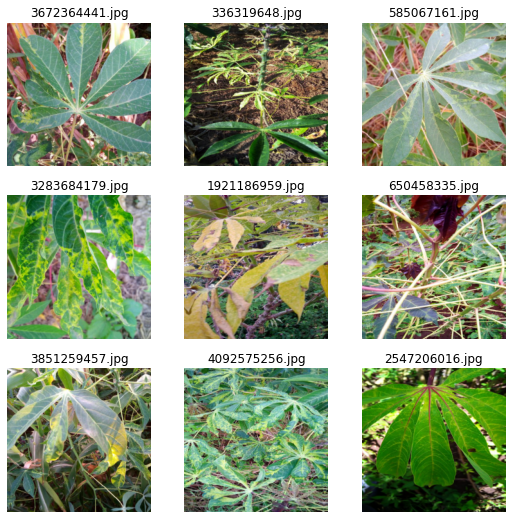

In [17]:
dls.show_batch()

# Model training

Let's train a simple EfficientNet-B3 model. We will use the wonderful [timm](https://github.com/rwightman/pytorch-image-models) package by Ross Wightman to define the model.

In fastai, the trainer class is the `Learner`, which takes in the data, model, optimizer, loss function, etc. and allows you to train models, make predictions, etc.

When training common CNN models like ResNets, we typically can use the `cnn_learner` function which creates a `Learner` object that allows us to train a provided model with the given dataloaders. However, `cnn_learner` doesn't support the models from timm out-of-the-box. Zach Mueller (@muellerzr) [has written some simple functions](https://walkwithfastai.com/vision.external.timm) to make it very easy to create Learner objects for timm models.

In [18]:
from timm import create_model
from fastai.vision.learner import _update_first_layer


def create_timm_body(arch:str, pretrained=True, cut=None, n_in=3):
    "Creates a body from any model in the `timm` library."
    model = create_model(arch, pretrained=pretrained, num_classes=0, global_pool='')
    _update_first_layer(model, n_in, pretrained)
    if cut is None:
        ll = list(enumerate(model.children()))
        cut = next(i for i,o in reversed(ll) if has_pool_type(o))
    if isinstance(cut, int): return nn.Sequential(*list(model.children())[:cut])
    elif callable(cut): return cut(model)
    else: raise NamedError("cut must be either integer or function")

        
def create_timm_model(arch:str, n_out, cut=None, pretrained=True, n_in=3, init=nn.init.kaiming_normal_, custom_head=None,
                     concat_pool=True, **kwargs):
    "Create custom architecture using `arch`, `n_in` and `n_out` from the `timm` library"
    body = create_timm_body(arch, pretrained, None, n_in)
    if custom_head is None:
        nf = num_features_model(nn.Sequential(*body.children())) * (2 if concat_pool else 1)
        head = create_head(nf, n_out, concat_pool=concat_pool, **kwargs)
    else: head = custom_head
    model = nn.Sequential(body, head)
    if init is not None: apply_init(model[1], init)
    return model

In [19]:
def timm_learner(dls, arch:str, loss_func=None, pretrained=True, cut=None, splitter=None,
                y_range=None, config=None, n_out=None, normalize=True, **kwargs):
    "Build a convnet style learner from `dls` and `arch` using the `timm` library"
    if config is None: config = {}
    if n_out is None: n_out = get_c(dls)
    assert n_out, "`n_out` is not defined, and could not be inferred from data, set `dls.c` or pass `n_out`"
    if y_range is None and 'y_range' in config: y_range = config.pop('y_range')
    model = create_timm_model(arch, n_out, default_split, pretrained, y_range=y_range, **config)
    learn = Learner(dls, model, loss_func=loss_func, splitter=default_split, **kwargs)
    if pretrained: learn.freeze()
    return learn

Let's now create our `Learner` object. We will also use common state-of-the-art training techniques like label smoothing and Ranger optimizer, which are provided in fastai. We can also use mixed precision very easily:

In [20]:
learn = timm_learner(dls, 
                    'tf_efficientnet_b3_ns', 
                     opt_func = ranger,
                     loss_func=LabelSmoothingCrossEntropy(),
                     metrics = [accuracy]).to_native_fp16()

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b3_ns-9d44bf68.pth" to /home/leo/.cache/torch/hub/checkpoints/tf_efficientnet_b3_ns-9d44bf68.pth


We are now provided with a Learner object which has a frozen model (only the weights of the head of the model can be updated). In order to train a model, we need to find the most optimal learning rate, which can be done with fastai's learning rate finder:

https://www.kaggle.com/c/jigsaw-unintended-bias-in-toxicity-classification/discussion/91081

In [34]:
import torch
torch.cuda.empty_cache()

# Metrics

The metric of this competition is accuracy – the ratio of the number of samples predicted correctly to the total number of samples.

# Ideas

**Augmentation** Since we have a fairly limited number of some classes, we can use augmentation using the [albumentations](https://albumentations.ai/) library.

# Sources
- [Cassava Leaf Disease - Exploratory Data Analysis](https://www.kaggle.com/ihelon/cassava-leaf-disease-exploratory-data-analysis) by Yaroslav Isaienkov (`ihelon`)
- [Cassava classification - EDA & fastai starter](https://www.kaggle.com/tanlikesmath/cassava-classification-eda-fastai-starter) by `ilovescience`